# Multi-Armed Bandits
*Notes from Reinforcement Learning Introduction Chapter 2*

Multi-armed bandit problems are some of the simplest reinforcement learning (RL) problems to solve. We have an agent which we allow to choose actions, and each action has a reward that is returned according to a given, underlying probability distribution. The game is played over many episodes (single actions in this case) and the goal is to maximize your reward.
An easy picture is to think of choosing between k
-many one-armed bandits (i.e. slot machines) or one big slot machine with k

arms. Each arm you pull has a different reward associated with it. You're given 1,000 quarters, so you need to develop some kind of strategy to get the most bang for your buck.
One way to approach this, is to select each one in turn and keep track of how much you received, then keep going back to the one that paid out the most. This is possible, but, as stated before, each bandit has an underlying probability distribution associated with it, meaning that you may need more samples before finding the right one. But, each pull you spend trying to figure out the best bandit to play takes you away from maximizing your reward. This basic balancing act is known as the explore-exploit dilemma. Forms of this basic problem come up in areas outside of AI and RL, such as in choosing a career, finance, human psychology, and even medical ethics (although, I think my favorite proposed use case relates to the suggestion that, due to its richness, it be given to Nazi Germany during WWII, "as the ultimate form of intellectual sabotage.").

## TL;DR

We introduce multi-armed bandit problems and develop a framework for solving these problems as well as examples. In this post, we'll focus on ϵ−greedy, ϵ−decay, and optimistic strategies.

## Problem Setup

To get started, let's describe the problem in a bit more technical detail. What we wish to do, is develop an estimate $Q_t(a)$
:
$$Q_t(a)=\E[R_n \mid A_n=a]$$

Where $Q_n(a)$ is the estimated, expected reward ($R_n$), when action $A_n$ is taken at step $n$. 
We're going to iteratively build a model that will converge towards the true value of each action. 
We're going to use a Gaussian (normal) distribution for all of the underlying probability distributions that we'll explore so that the mean corresponds to the true value (after all, given enough samples, we would expect our rewards to converge to the mean of the selected action).
The simplest way to proceed, is to take the greedy action or take the action we think will maximize our reward at each time step. Another way of writing this is:
$$A_n=\max_a(Q_n(a))$$

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

There are plenty of different ways to define this class. I did it so that once we initialize our problem, we just call the run() method and can examine the outputs. By default, the average rewards for each arm are drawn from a normal distribution around 0. Setting mu="sequence" will cause the rewards to range from 0 to k−1 to make it easy to know which actions provide the best rewards when evaluating the results and which actions were taken. 

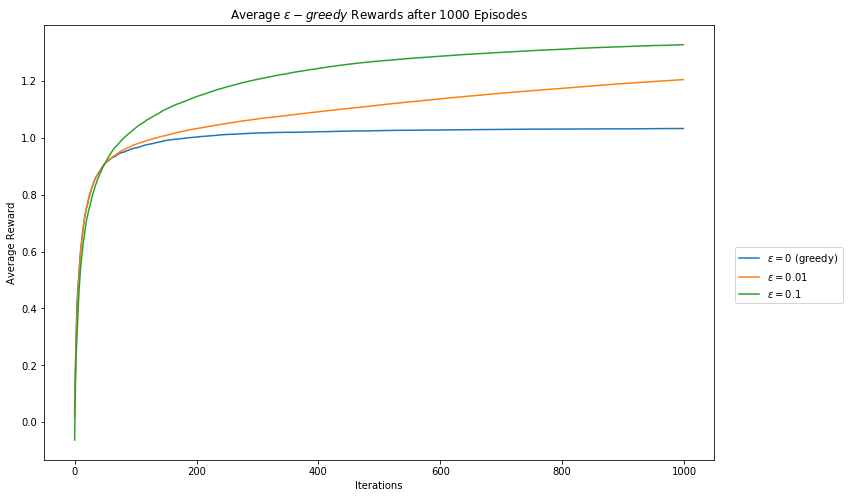

In [3]:
k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters)
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

Looking at the results, the greedy function underperforms the other two consistently, with ϵ=0.01 coming in between the two and ϵ=0.1 performing the best of the three here. Below, we can see the effect is clearer using the sequence argument, and can get a feel for how often the optimal action is taken per episode because the 

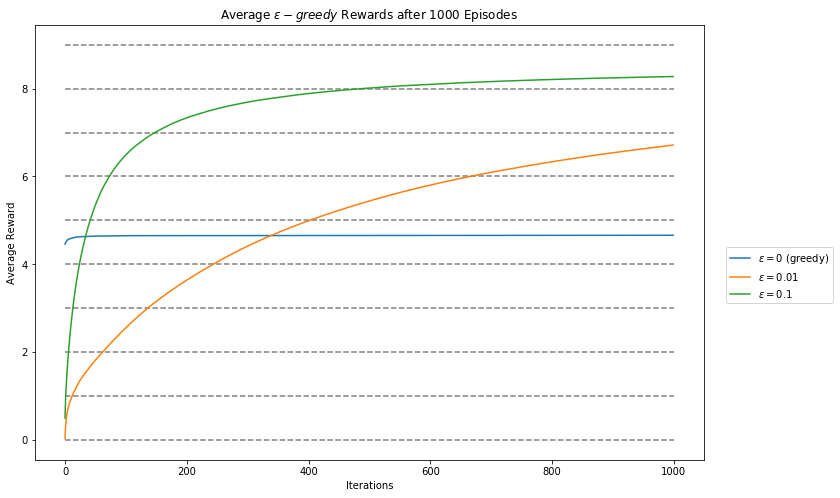

In [4]:
k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, mu='sequence')
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
    # Average actions per episode
    eps_0_selection = eps_0_selection + (
        eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (
        eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (
        eps_1.k_n - eps_1_selection) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
for i in range(k):
    plt.hlines(eps_0.mu[i], xmin=0,
              xmax=iters, alpha=0.5,
              linestyle="--")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

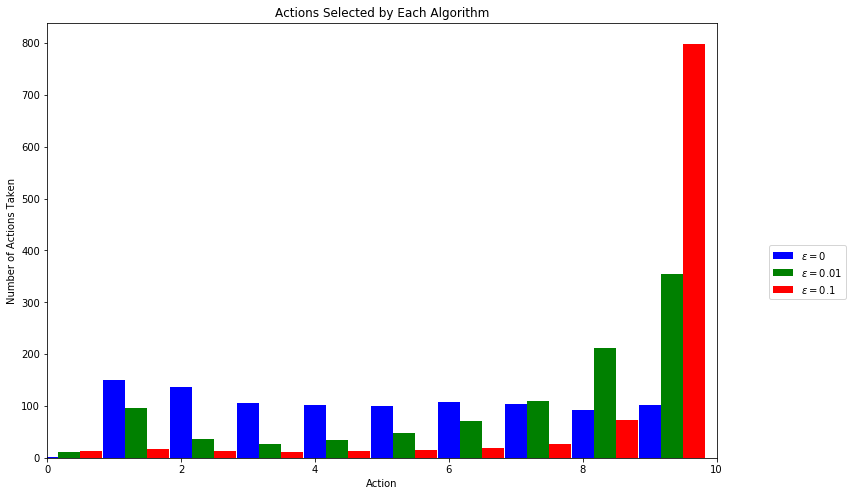

Percentage of actions selected:


In [5]:
bins = np.linspace(0, k-1, k)

plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, 
        width = 0.33, color='b', 
        label="$\epsilon=0$")
plt.bar(bins+0.33, eps_01_selection,
        width=0.33, color='g', 
        label="$\epsilon=0.01$")
plt.bar(bins+0.66, eps_1_selection, 
        width=0.33, color='r',
        label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([eps_0_selection, eps_01_selection,
                   eps_1_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', '$\epsilon=0.01$', '$\epsilon=0.1$'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

Viewing the average selection of the algorithms, we see why the larger ϵ value performs well, it takes the optimal selection 80% of the time.
Play around with the different values of both ϵ and k to see how these results change. For example, decreasing the search space would likely benefit smaller values of ϵ as exploration would be less beneficial and vice versa. Additionally, increasing the number of iterations will begin to benefit the lower value of ϵ because it will have less random noise.

# ϵ−decay Strategies

The ϵ−greedy
strategies have an obvious weakness in that they continue to include random noise no matter how many examples they see. It would be better for these to settle on an optimal solution and continue to exploit 

In [6]:
class eps_decay_bandit:
    '''
    epsilon-decay k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, iters, mu='random'):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

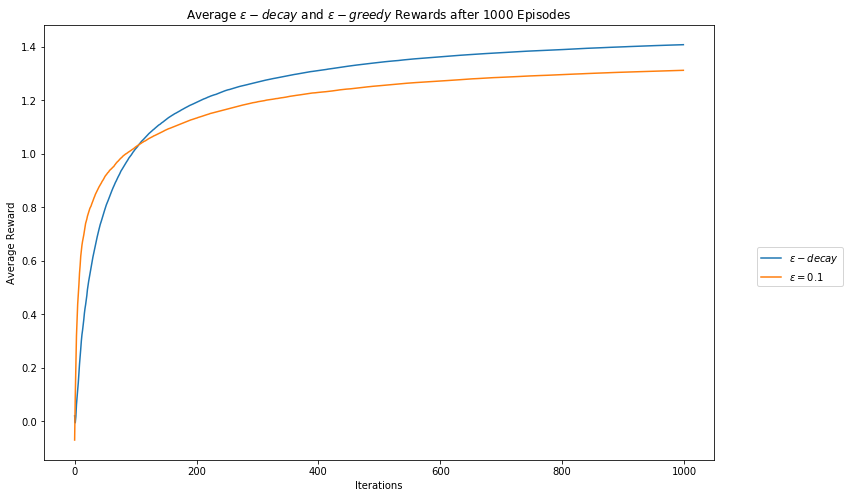

In [7]:
k = 10
iters = 1000

eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters)
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())
    
    # Run experiments
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

The ϵ−decay strategy outperforms our previous best algorithm as it sticks to the optimal action once it is found.
There's one last method to balance the explore-exploit dilemma in k-bandit problems, optimistic initial values.

## Optimistic Initial Values

This approach differs significantly from the previous examples we explored because it does not introduce random noise to find the best action, A∗n. 
Instead, we overestimate the rewards of all the actions and continuously select the maximium. In this case, the algorithm explores early on as it seeks to maximize its returns while additional information allows the values to converge to their true means. This approach does require some additional background knowledge to be included in the set up because we need at least some idea of what the r

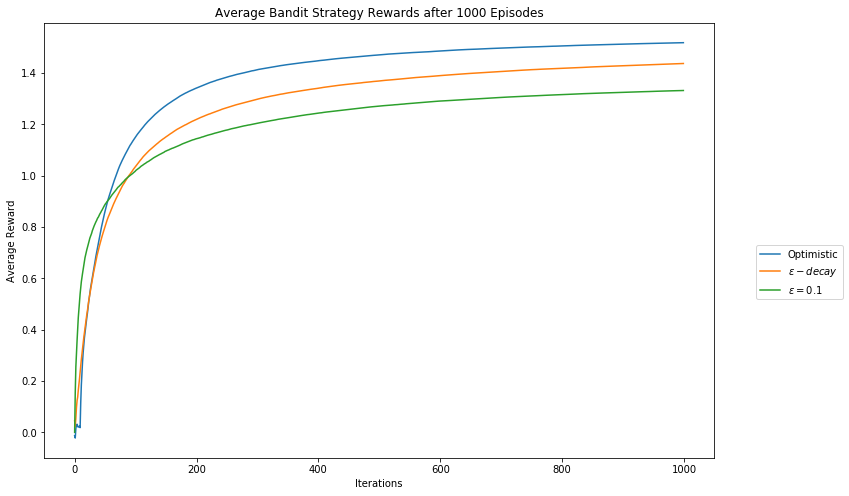

In [8]:
k = 10
iters = 1000

oiv_rewards = np.zeros(iters)
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Select initial values
oiv_init = np.repeat(5., k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    oiv_bandit = eps_bandit(k, 0, iters)
    oiv_bandit.k_reward = oiv_init.copy()
    oiv_bandit.k_n = np.ones(k)
    eps_decay = eps_decay_bandit(k, iters, oiv_bandit.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, oiv_bandit.mu.copy())
    
    # Run experiments
    oiv_bandit.run()
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    oiv_rewards = oiv_rewards + (
        oiv_bandit.reward - oiv_rewards) / (i + 1)
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Bandit Strategy Rewards after " + str(episodes) + " Episodes")
plt.show()

We can see that, in this case, the optimistic initial value approach outperformed both our ϵ−greedy and the ϵ−decay algorithms. We can see too, the estimates the algorithm has for each of arms in the last episode.

In [9]:
df = pd.DataFrame({"number of selections": oiv_bandit.k_n - 1,
                  "actual reward": oiv_bandit.mu,
                  "estimated reward": oiv_bandit.k_reward})
df

The estimates are far off the actual rewards in all cases except the one with 961 pulls. This highlights a lot of what we'll be doing in reinforcement learning more generally. We don't necessarily care about acquiring accurate representations of the environment we are interacting with. Instead, we intend to learn optimal behavior in those situations and seek to behave accordingly. This can open up a whole discussion about model-free versus model-based learning that we'll have to postpone for another time.
There are other bandit methods that we will explore such as the gradient bandits, upper confidence bound (UCB) methods, and nonstationary problems. Plus, many others like dueling bandits, cluster bandits, collaborative filtering bandits, spatially correlated bandits, distributed bandtis, adversarial bandits, and contextual bandits which are open to exploration. Starting to wonder if we haven't been hit with intellectual sabotage...